## Import Packages and Reading of Data

In [1]:
import re
import demoji
import emoji
import warnings
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from datetime import datetime
from datetime import date
from collections import OrderedDict
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
df_metadata = pd.read_csv("pre_metadata_dataset.csv")

In [3]:
df_metadata

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,isBot,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,account_age_in_days,average_tweets_per_day,followers_following_count
0,0,0,1,1959,2708,405158,157,1,0,6,0,12,0,0,0,0,1,1,5212,77.735610,5304972
1,0,0,0,371,0,33172,10,1,0,13,0,14,0,0,0,0,1,1,4985,6.654363,0
2,0,0,0,36,0,548,0,1,1,13,1,16,0,0,0,0,1,0,4204,0.130352,0
3,0,0,1,30,148,93,1,1,1,12,0,12,0,0,0,0,1,1,3301,0.028173,4440
4,0,0,1,1089,2283,9098,34,1,0,10,0,14,0,0,0,1,1,1,5232,1.738914,2486187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20284,0,0,1,72,76,4161,1,1,0,11,0,12,0,0,0,0,0,0,5367,0.775293,5472
20285,0,0,0,314,107,20915,9,1,0,13,1,14,0,0,0,1,1,1,5257,3.978505,33598
20286,0,0,1,2981,2523,4991,46,1,0,14,0,16,0,0,3,1,1,1,5134,0.972146,7521063
20287,0,0,0,170,180,7820,4,1,0,11,0,12,0,0,0,0,1,0,5387,1.451643,30600


## Exploratory Data Analysis
* Heatmap
* Barchart
* Histogram
* Boxplot

In [4]:
# Functions to plot data distributions
def plot_multiple_histograms(data: pd.DataFrame,
                             grouped_col: str,
                             target_col: str,
                             data_labels: dict):
    # Plot
    plt.figure(figsize=(12, 10))
    title = "\n"
    labels: list = list(data_labels.keys())
    for j, i in enumerate(labels):
        x = data.loc[data[grouped_col] == i, target_col]
        mu_x = round(float(np.mean(x)), 3)
        sigma_x = round(float(np.std(x)), 3)
        ax = sns.distplot(x, color=data_labels.get(i), label=i, hist_kws=dict(alpha=.1),
                          kde_kws={'linewidth': 2})
        ax.axvline(mu_x, color=data_labels.get(i), linestyle='--')
        ax.set(xlabel=f"{target_col.title()}", ylabel='Density')
        title += f"Parameters {str(i)}: $G(\mu=$ {mu_x}, $\sigma=$ {sigma_x}) \n"
        ax.set_title(target_col.title() + title)
    plt.legend(title="Account Type")
    plt.grid()
    plt.tight_layout()
    # bg = fig.patch
    # bg.set_facecolor("white")
    # plt.savefig(f'..\\Images\\Histogram\\{target_col}.jpg', facecolor=fig.get_facecolor())
    plt.show()


def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "viridis"):
    plt.figure(figsize=(12, 10))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        mean = round(v, 2)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    # bg = fig.patch
    # bg.set_facecolor("white")
    # plt.savefig(f'..\\Images\\Boxplot\\{target_col}.jpg', facecolor=fig.get_facecolor())
    plt.show()

def add_labels(plot):
    for p in plot.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                y+height*1.01,
                str(format(int(p.get_height()), ',d')),
                ha='center')

In [5]:
palette: str = "viridis"
grouped: str = "isBot"
default_value: str = "unknown"

def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    labels: list = df[column].unique().tolist()
    colors: list = sns.color_palette(palette, len(labels))
    data_labels: dict = dict(zip(labels, colors))
    return data_labels

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(
    df = df_metadata, column = grouped, palette = palette)

### Heatmap

In [6]:
heatmap_tweets = df_metadata[['isBot', 'verified', 'protected', 'location', 'followers_count', 
                              'following_count', 'tweet_count', 'listed_count', 
                              'un_no_of_char', 'un_special_char',
                              'name_no_of_char', 'name_special_char',
                              'des_no_of_usertags', 'des_no_of_hashtags', 'des_external_links', 
                              'has_description', 'has_profile_image',
                              'account_age_in_days', 'average_tweets_per_day', 'followers_following_count']]

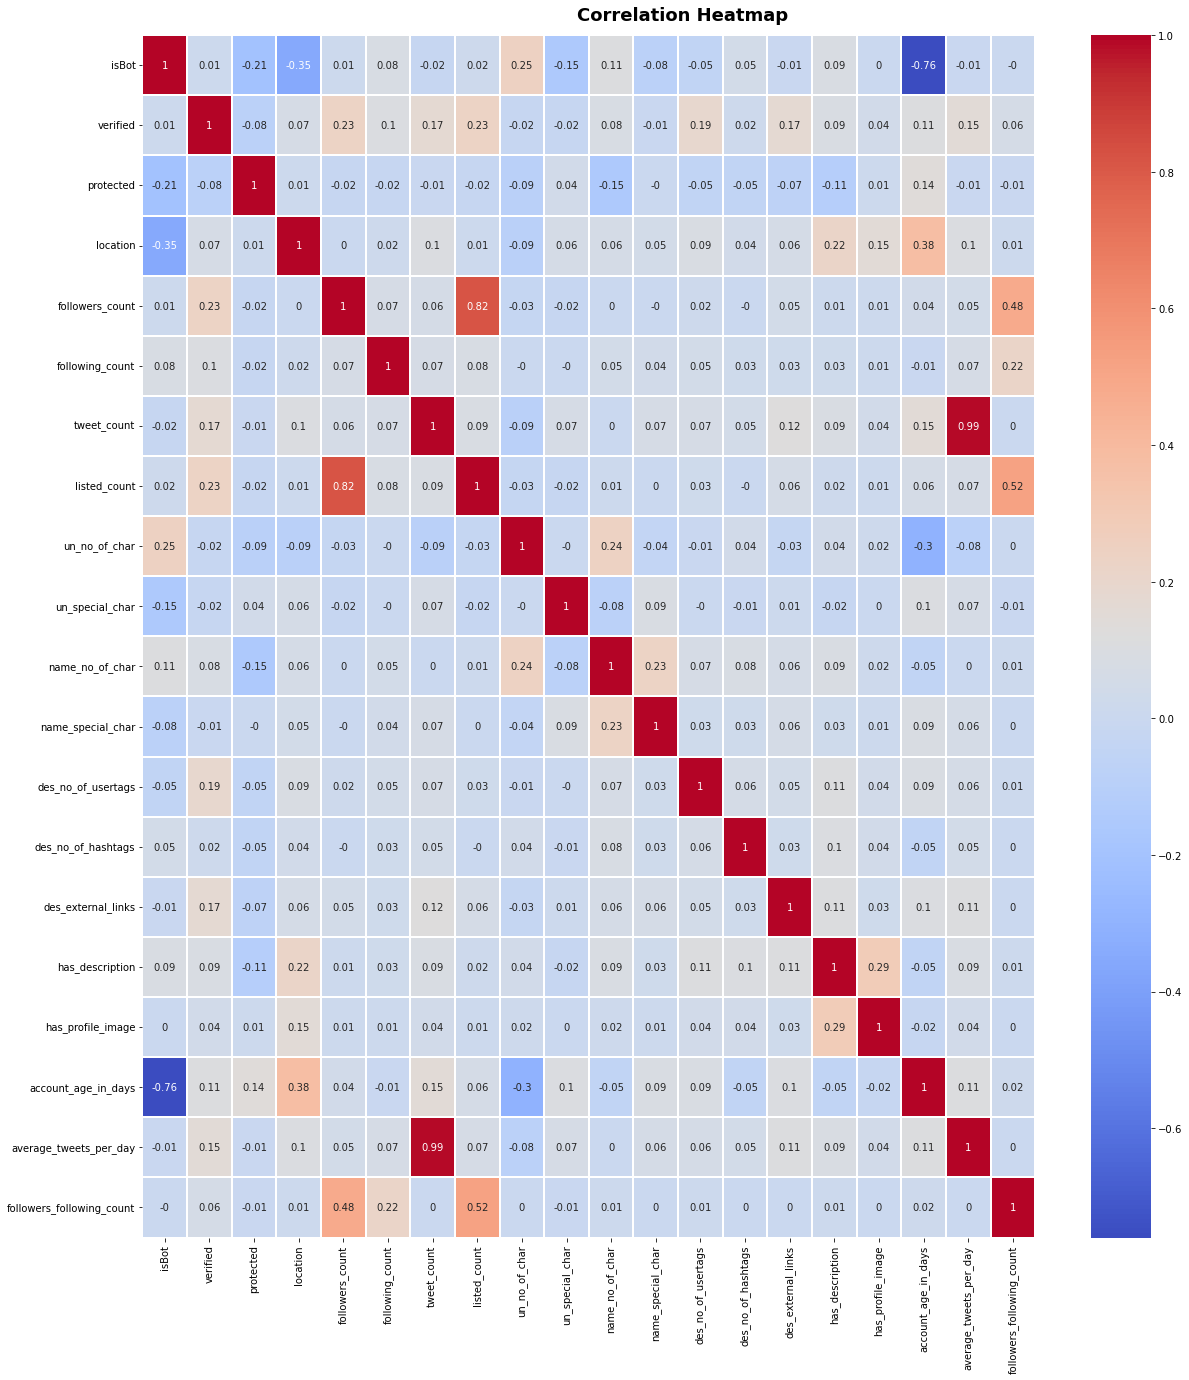

In [7]:
fig, axs = plt.subplots(1,1, figsize=(20,20))
hm = sns.heatmap(round(heatmap_tweets.corr(),2), 
                 ax=axs,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm",  # Color Map.
                 #square=True,     # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 linewidths=.05)
fig.subplots_adjust(top=0.96)
t = fig.suptitle('Correlation Heatmap', fontsize=18, fontweight='bold')

In [8]:
new_heatmap_tweets = df_metadata[['isBot', 'verified', 'protected', 'location', 'followers_count', 
                                  'following_count', 'tweet_count', 'listed_count', 
                                  'un_no_of_char', 'un_special_char',
                                  'name_no_of_char', 'name_special_char',
                                  'des_no_of_usertags', 'des_no_of_hashtags', 'des_external_links', 
                                  'has_description', 'has_profile_image']]

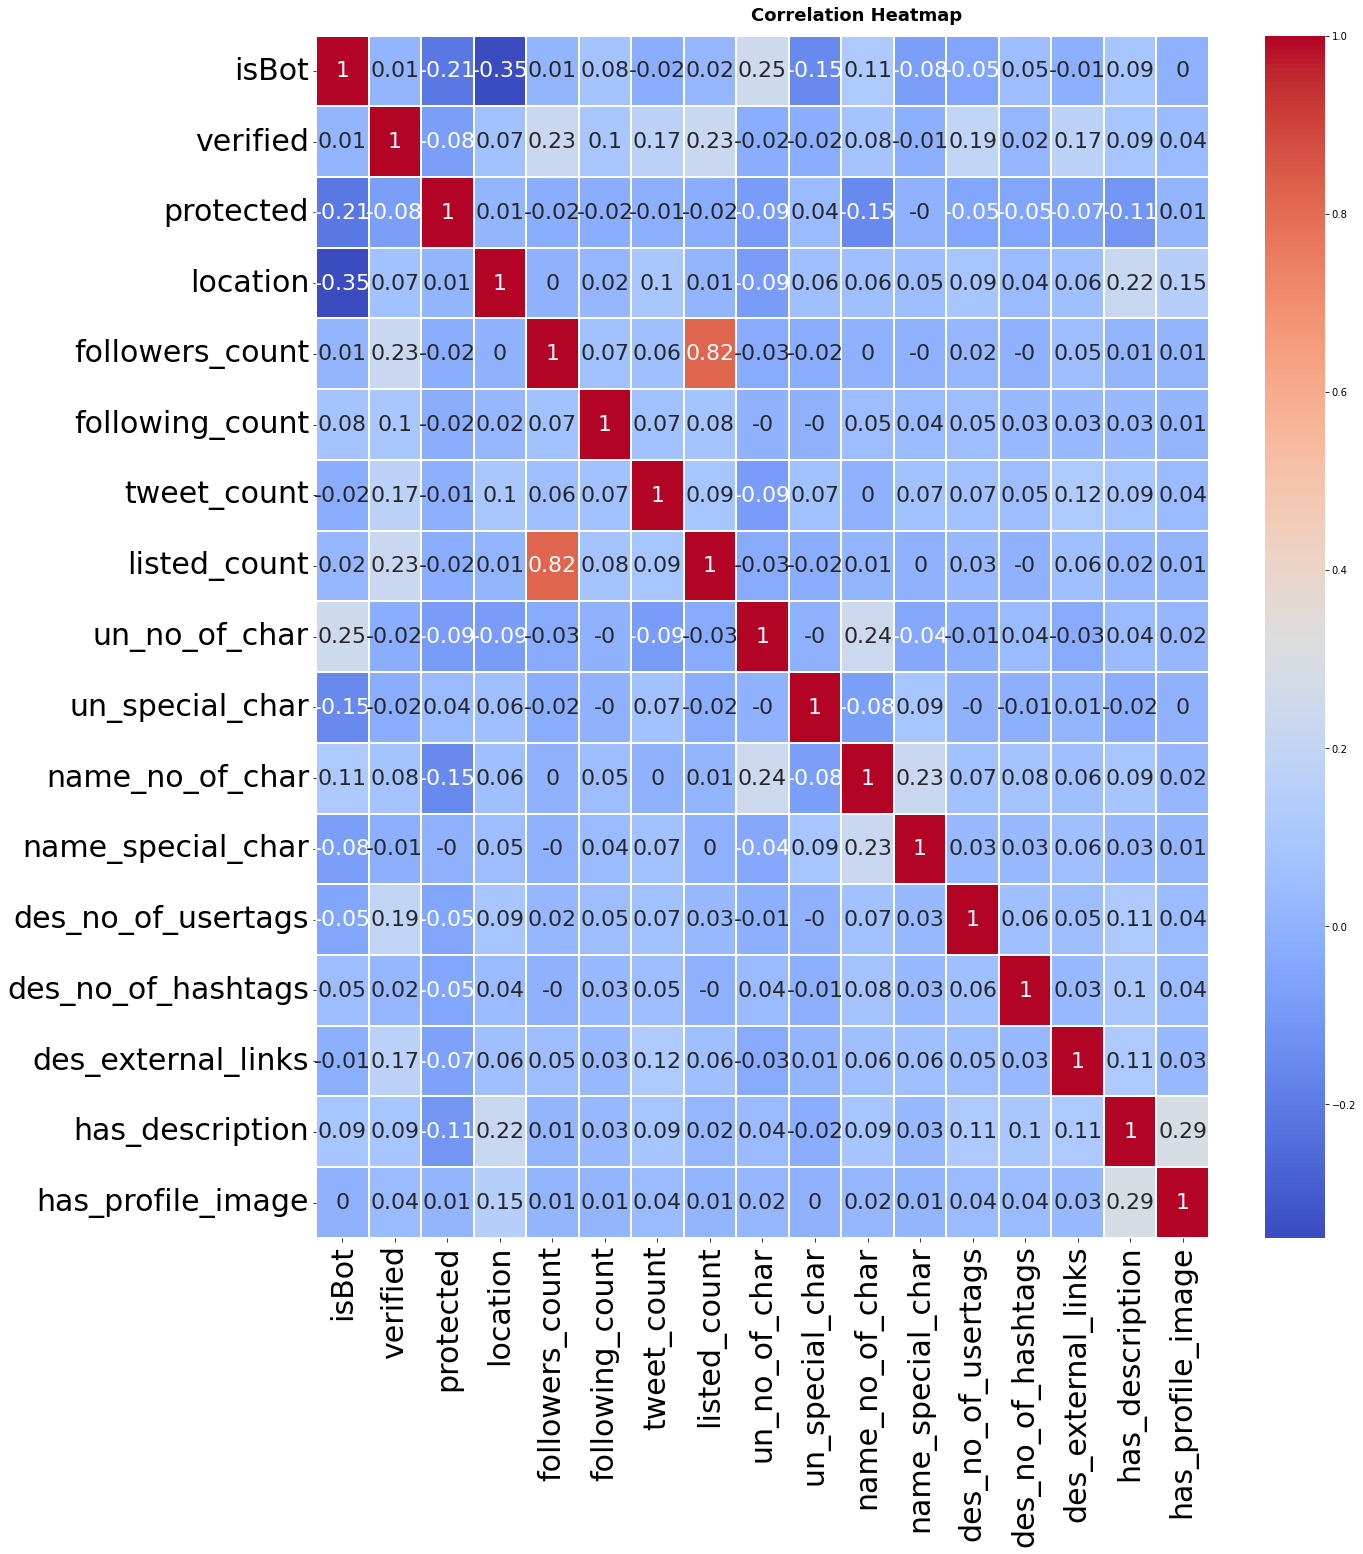

In [9]:
fig, axs = plt.subplots(1,1, figsize=(20,20))
hm = sns.heatmap(round(new_heatmap_tweets.corr(),2), 
                 ax=axs,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm",  # Color Map.
                 #square=True,     # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 linewidths=.05,  
                 annot_kws={"size": 22})
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 30)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 30)
fig.subplots_adjust(top=0.96)
t = fig.suptitle('Correlation Heatmap', fontsize=18, fontweight='bold')

In [10]:
new_df_metatdata = df_metadata.drop(columns=['account_age_in_days', 'average_tweets_per_day', 'followers_following_count'])
new_df_metatdata

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,isBot,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url
0,0,0,1,1959,2708,405158,157,1,0,6,0,12,0,0,0,0,1,1
1,0,0,0,371,0,33172,10,1,0,13,0,14,0,0,0,0,1,1
2,0,0,0,36,0,548,0,1,1,13,1,16,0,0,0,0,1,0
3,0,0,1,30,148,93,1,1,1,12,0,12,0,0,0,0,1,1
4,0,0,1,1089,2283,9098,34,1,0,10,0,14,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20284,0,0,1,72,76,4161,1,1,0,11,0,12,0,0,0,0,0,0
20285,0,0,0,314,107,20915,9,1,0,13,1,14,0,0,0,1,1,1
20286,0,0,1,2981,2523,4991,46,1,0,14,0,16,0,0,3,1,1,1
20287,0,0,0,170,180,7820,4,1,0,11,0,12,0,0,0,0,1,0


In [11]:
new_df_metatdata.to_csv("metadata_dataset.csv", index = False)

### Barchart
* To see count of each feature

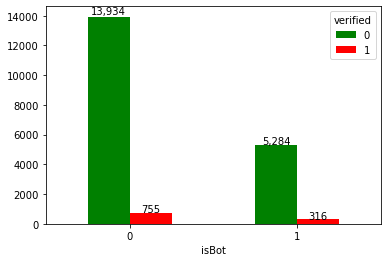

In [12]:
target_col: str = "verified"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot1 = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0)
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot1)

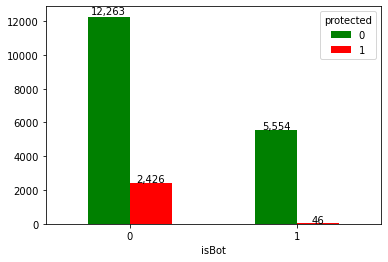

In [13]:
target_col: str = "protected"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot1 = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0)
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot1)

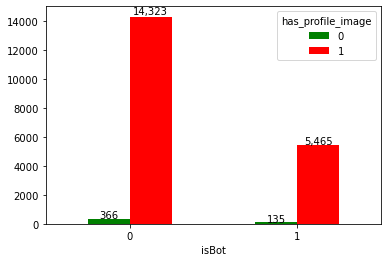

In [14]:
target_col: str = "has_profile_image"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot2 = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0) 
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot2)

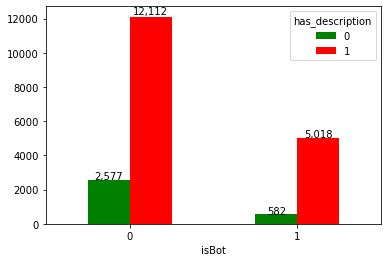

In [15]:
target_col: str = "has_description"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot2 = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0) 
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot2)

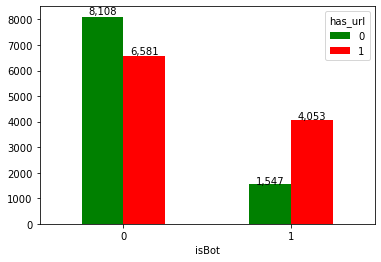

In [16]:
target_col: str = "has_url"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot2 = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0) 
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot2)

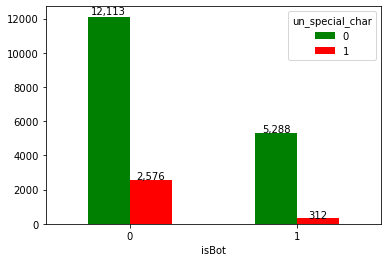

In [17]:
target_col: str = "un_special_char"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0)
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot)

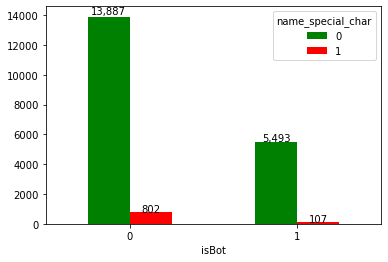

In [18]:
target_col: str = "name_special_char"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0) 
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot)

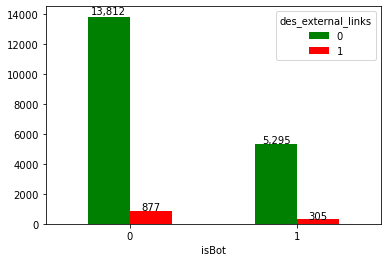

In [19]:
target_col: str = "des_external_links"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0) 
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot)

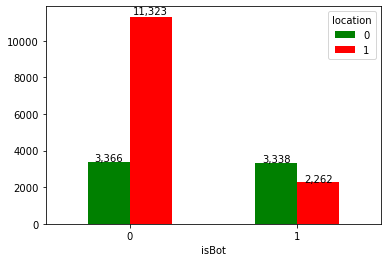

In [20]:
target_col: str = "location"
twitter_accounts_df2 = df_metadata.groupby([grouped, target_col])[grouped].count().unstack(target_col)
plot3 = twitter_accounts_df2.plot(kind='bar', stacked=False, color={1: "red", 0: "green"})
plt.xticks(rotation=0) 
# bg = fig.patch
# bg.set_facecolor("white")
# plt.savefig(f'..\\Images\\Barchart\\{target_col}.jpg', facecolor=fig.get_facecolor())
add_labels(plot3)

### Histogram and Boxplot

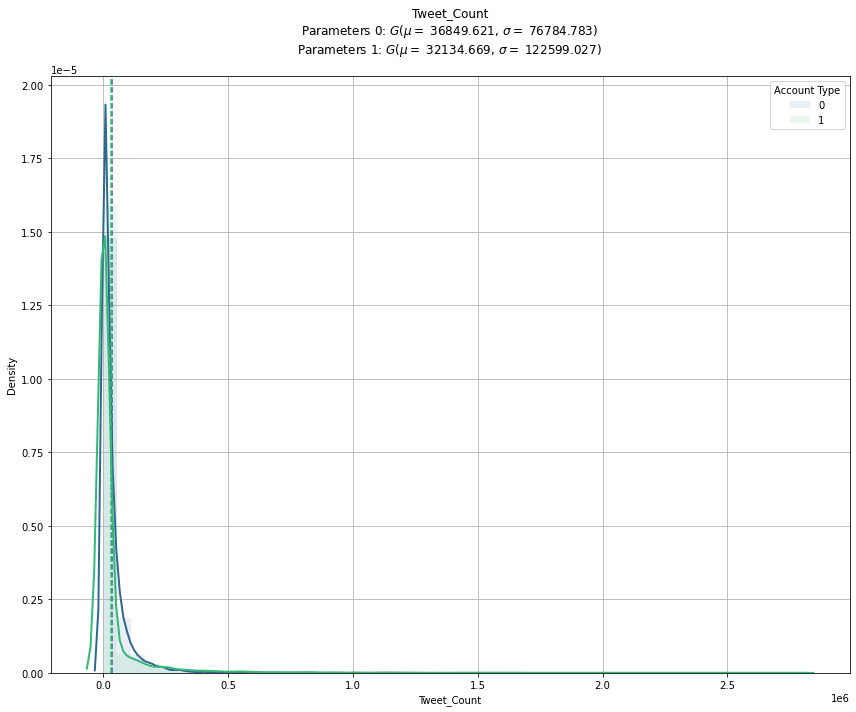

Skewness: 9.795086948974795


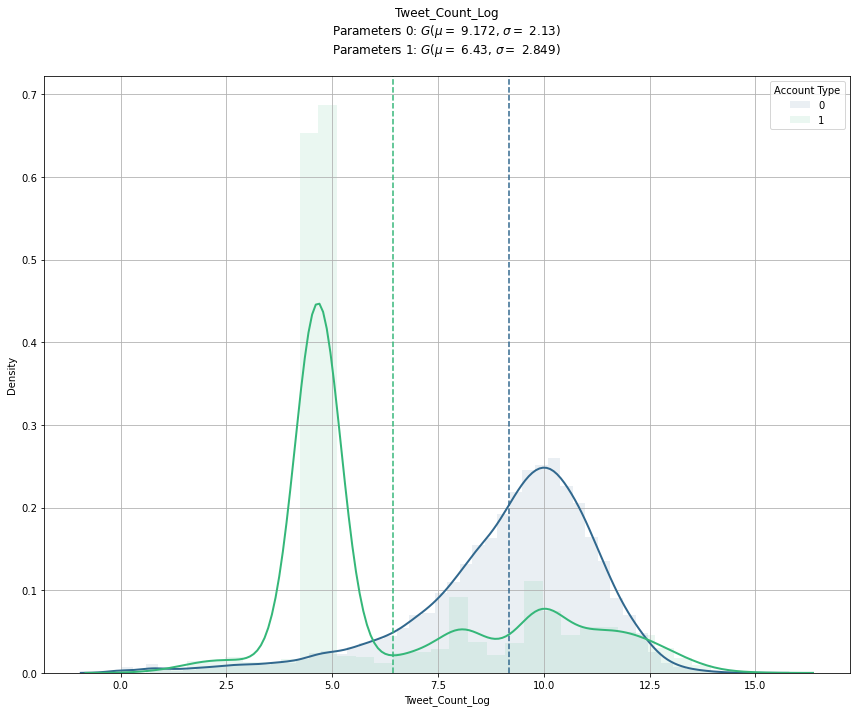

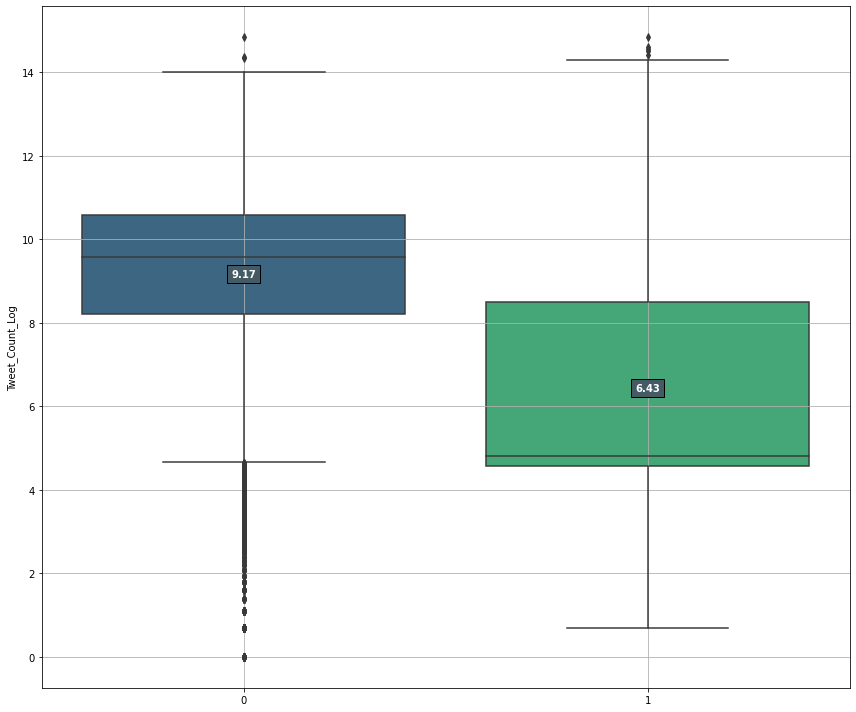

In [21]:
target: str = "tweet_count"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
s = skew(df_metadata['tweet_count'])
print (f'Skewness: {s}') #data is very skewed

#We log transform tweet_count to make trends in the data more interpretable. 
df_metadata['tweet_count_log'] = np.round(np.log(1 + df_metadata['tweet_count']), 3)
target: str = "tweet_count_log"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

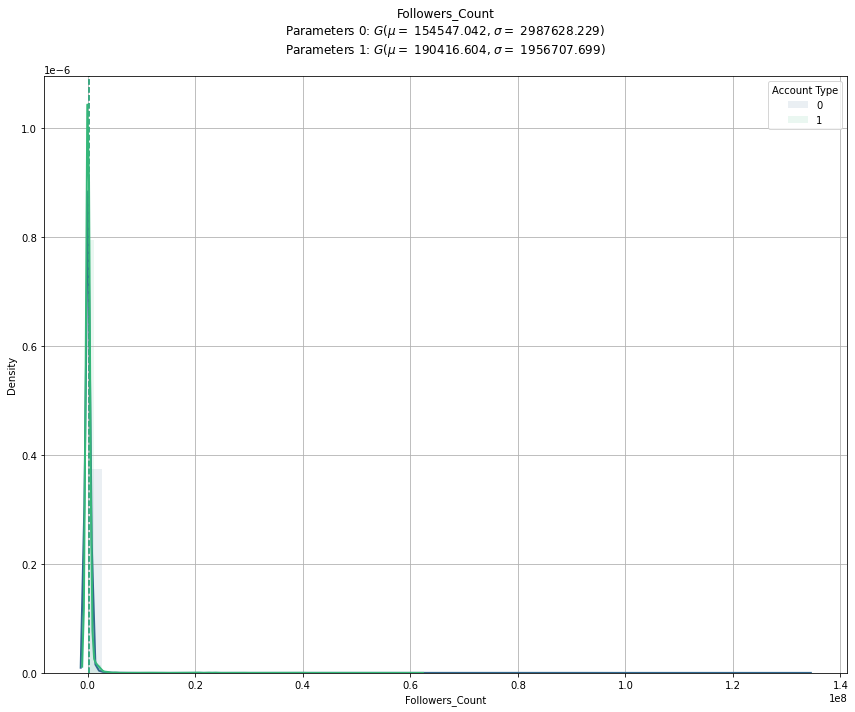

Skewness: 30.18315654287899


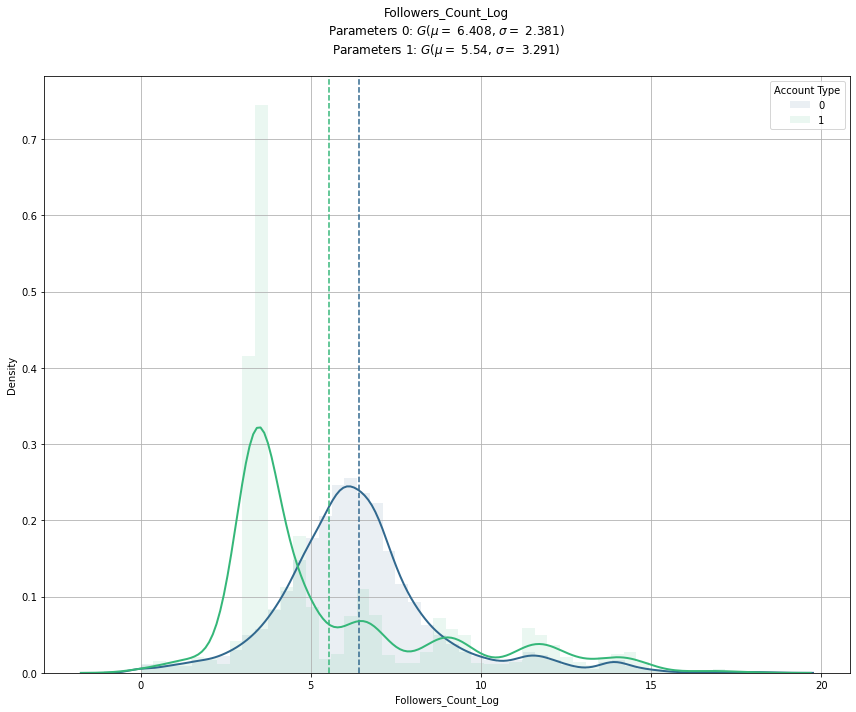

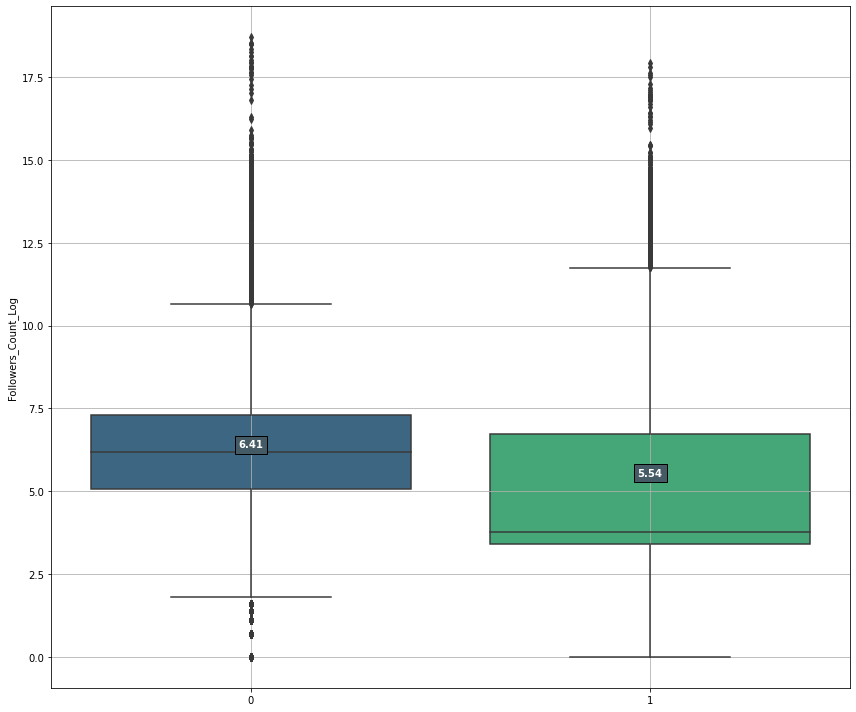

In [22]:
target: str = "followers_count"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
s = skew(df_metadata['followers_count'])
print (f'Skewness: {s}') #data is very skewed

#We log transform followers_count to make trends in the data more interpretable. 
df_metadata['followers_count_log'] = np.round(np.log(1 + df_metadata['followers_count']), 3)
target: str = "followers_count_log"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

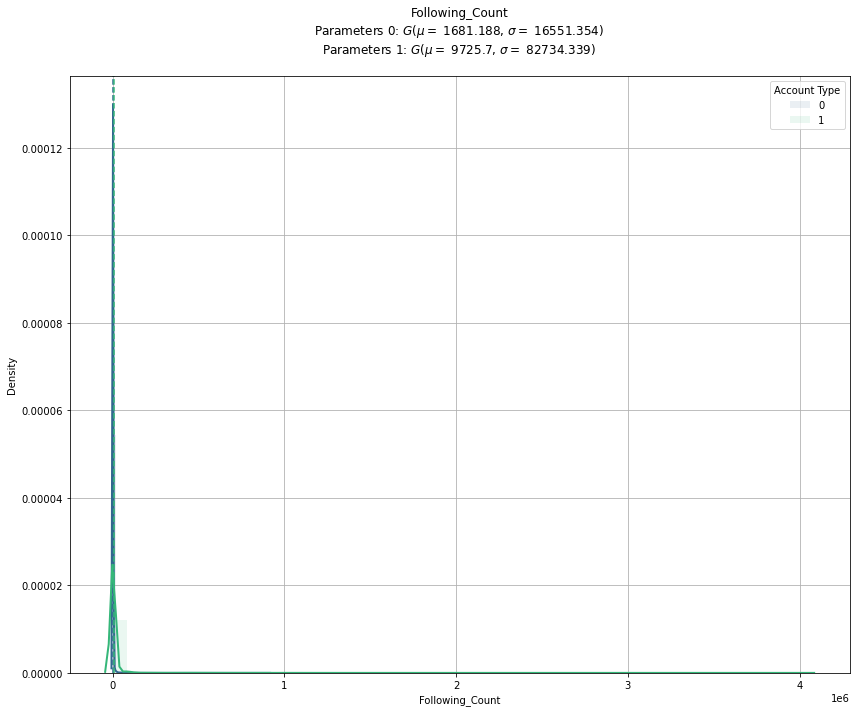

Skewness: 44.691852466153215


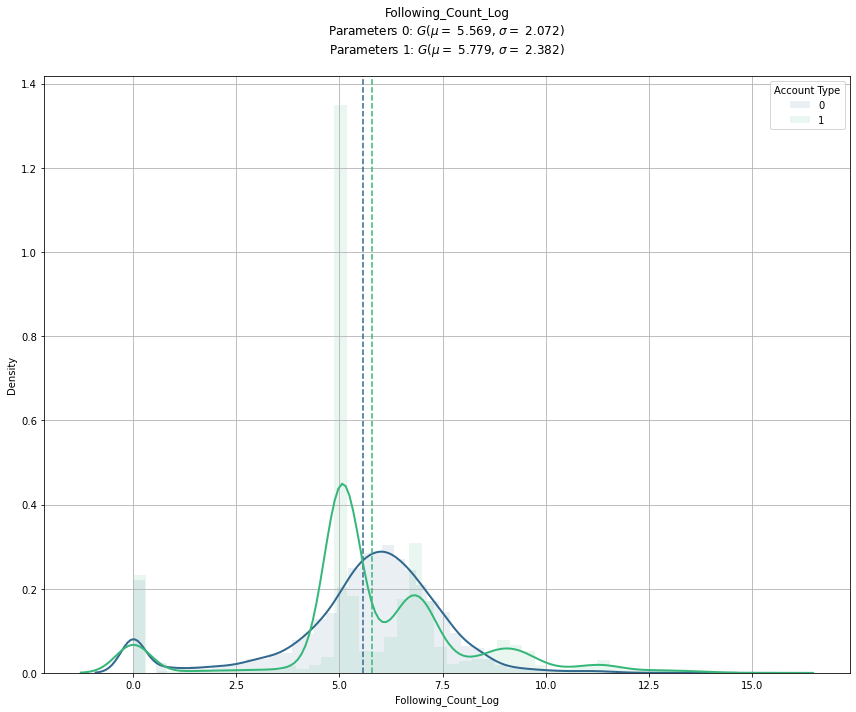

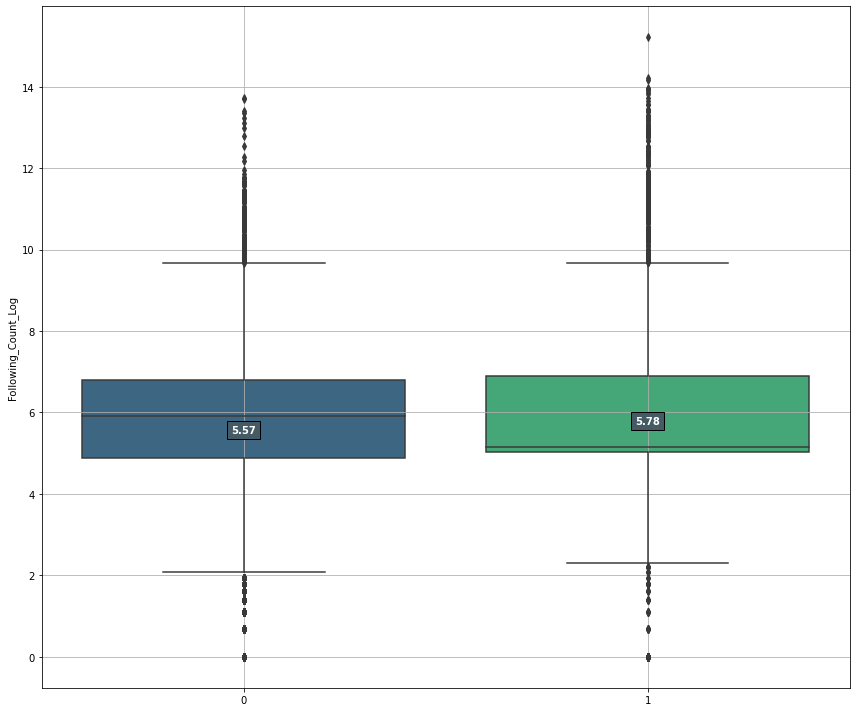

In [23]:
target: str = "following_count"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
s = skew(df_metadata['following_count'])
print (f'Skewness: {s}') #data is very skewed

#We log transform following_count to make trends in the data more interpretable. 
df_metadata['following_count_log'] = np.round(np.log(1 + df_metadata['following_count']), 3)
target: str = "following_count_log"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

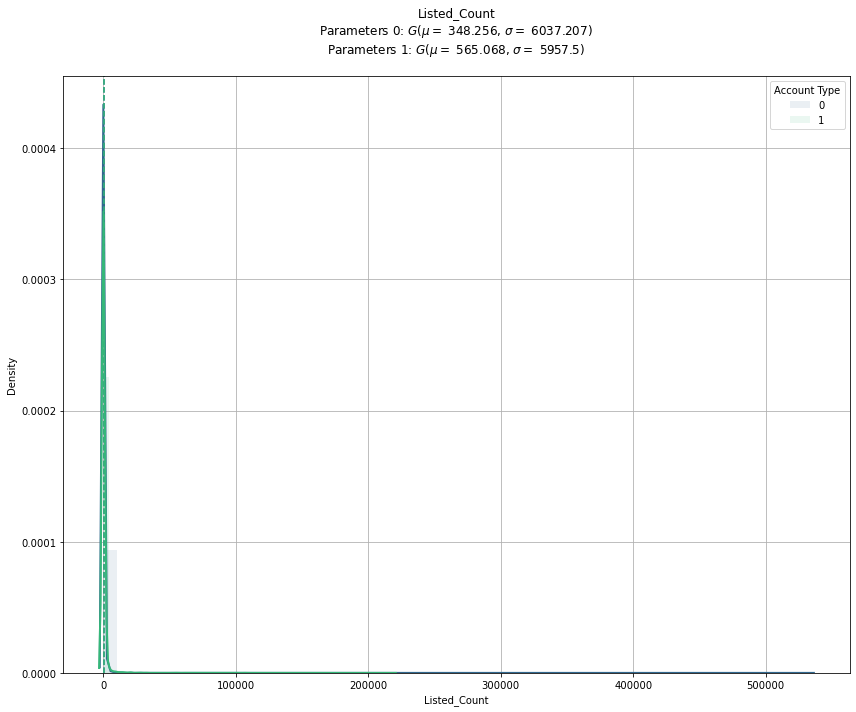

Skewness: 47.7917387924098


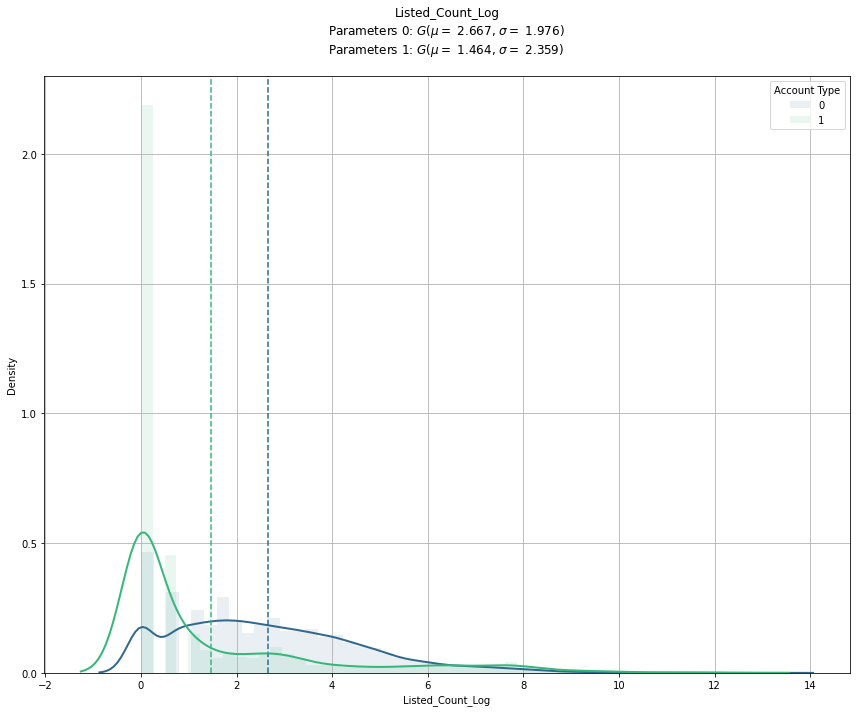

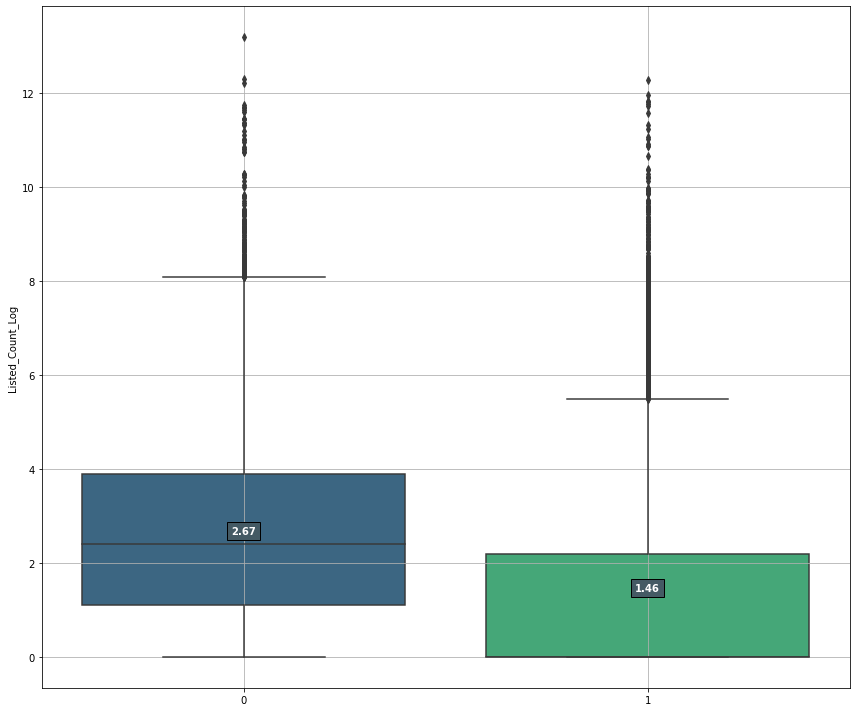

In [24]:
target: str = "listed_count"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
s = skew(df_metadata['listed_count'])
print (f'Skewness: {s}') #data is very skewed

#We log transform listed_count to make trends in the data more interpretable. 
df_metadata['listed_count_log'] = np.round(np.log(1 + df_metadata['listed_count']), 3)
target: str = "listed_count_log"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)
# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

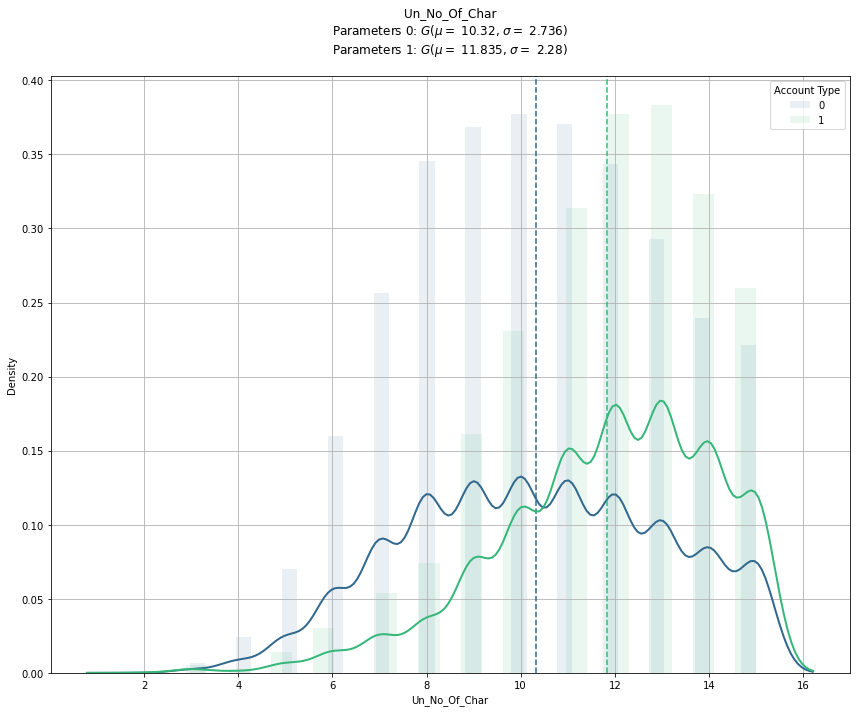

Skewness: -0.26904610817838104


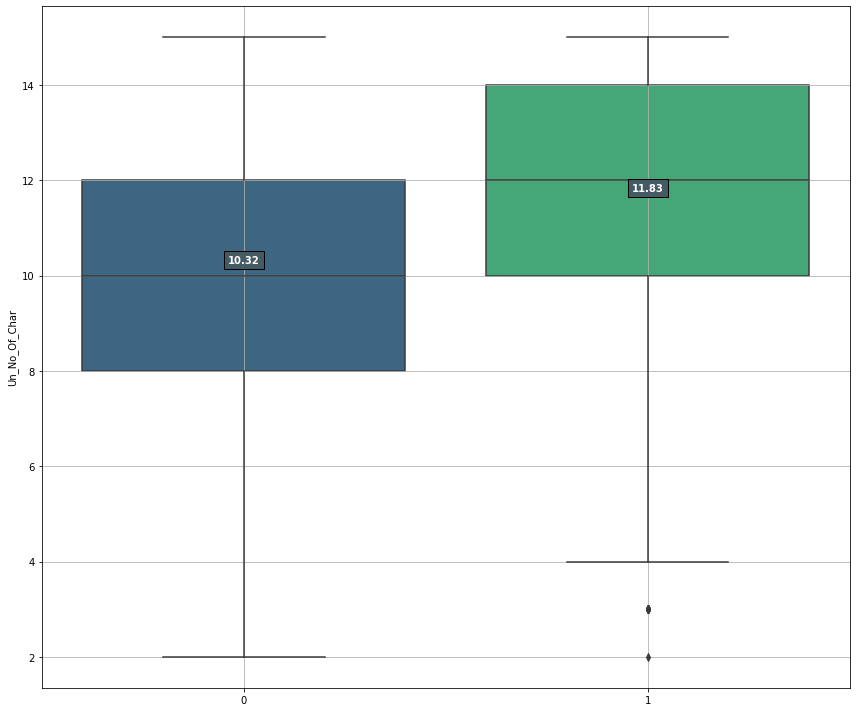

In [25]:
target: str = "un_no_of_char"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

s = skew(df_metadata['un_no_of_char'])
print (f'Skewness: {s}') #data distribution is fairly symmetrical

# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

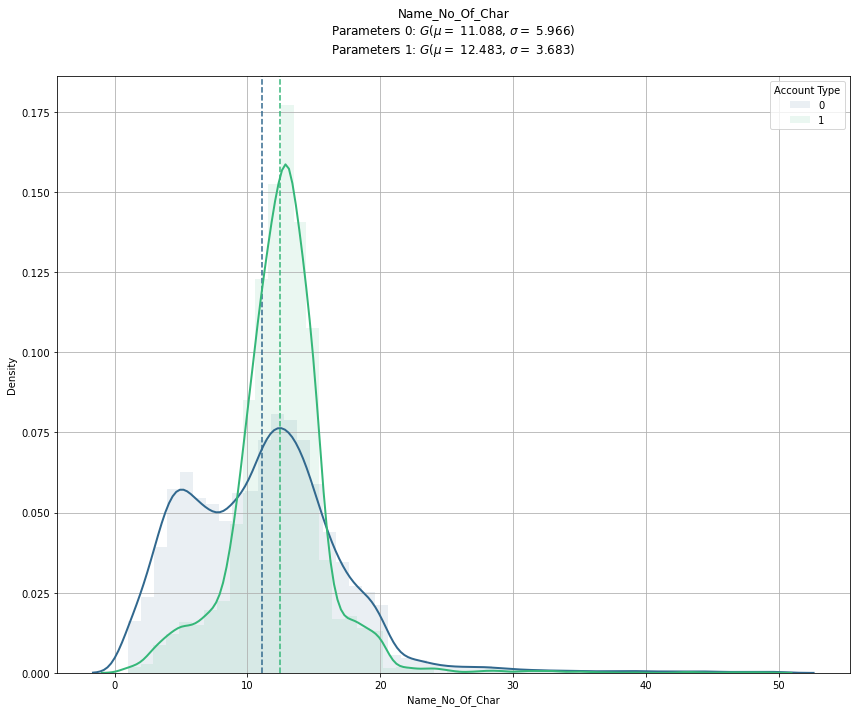

Skewness: 1.187049410740782


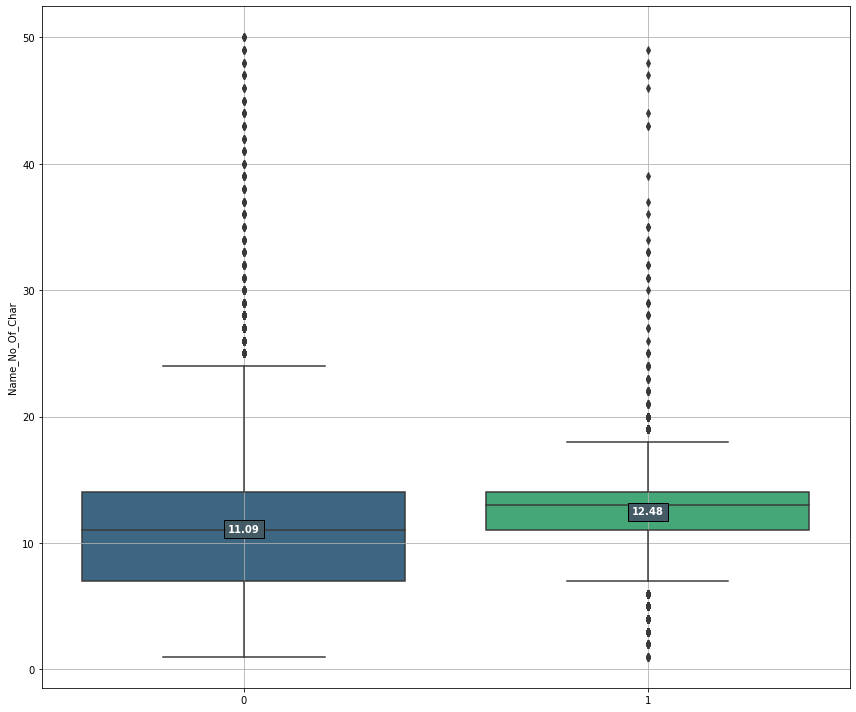

In [26]:
target: str = "name_no_of_char"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

s = skew(df_metadata['name_no_of_char'])
print (f'Skewness: {s}') #data distribution is fairly symmetrical

# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

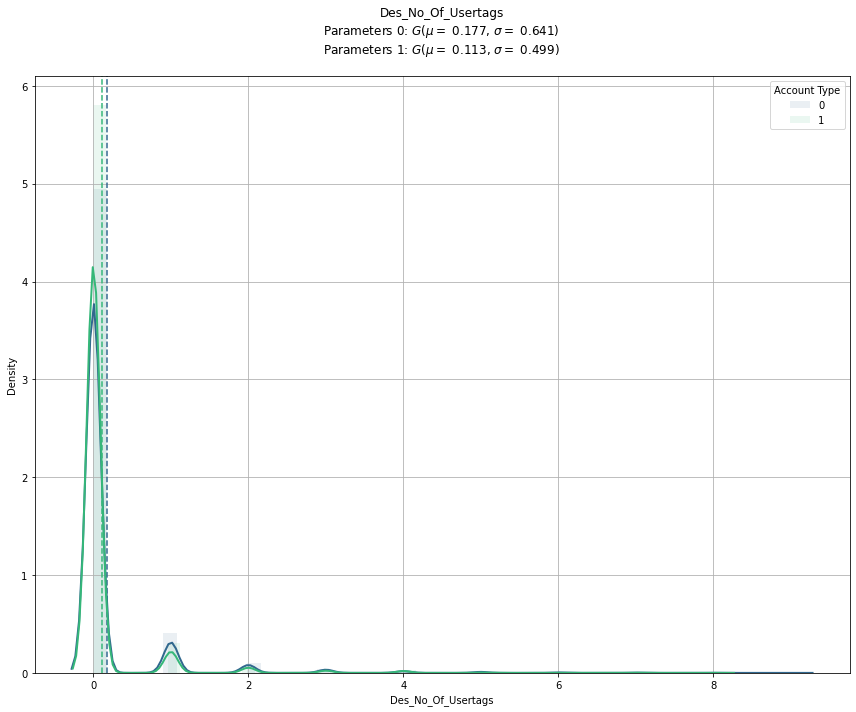

Skewness: 5.764330752048656


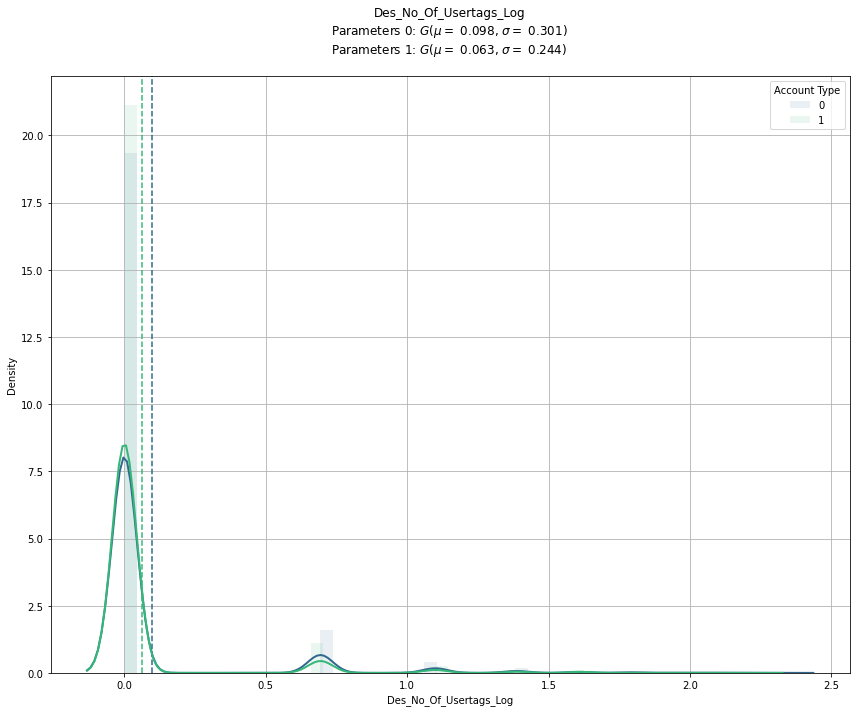

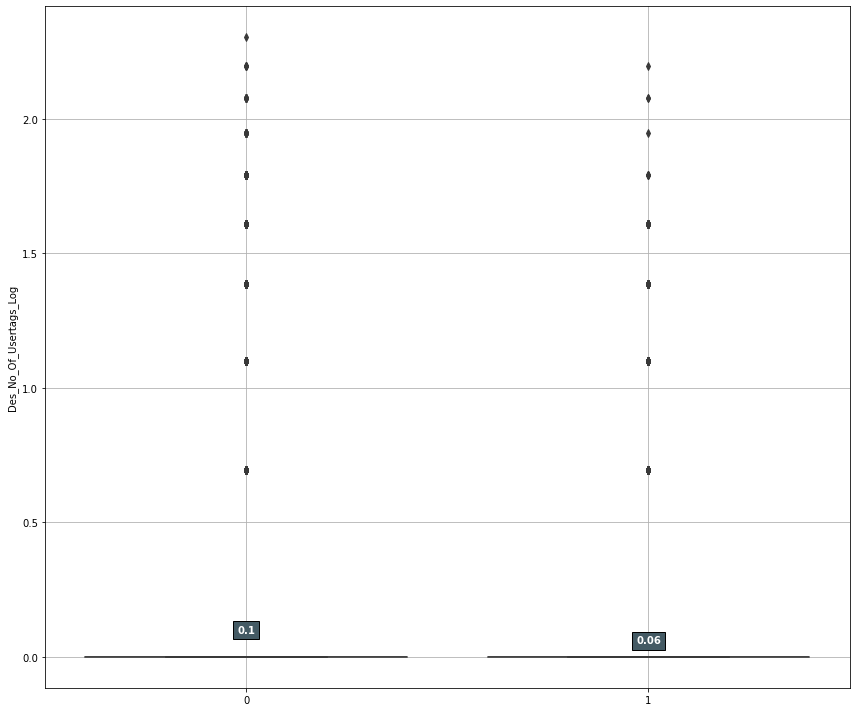

In [27]:
target: str = "des_no_of_usertags"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

s = skew(df_metadata['des_no_of_usertags'])
print (f'Skewness: {s}') #data is slightly skewed

#We log transform des_no_of_usertags to make trends in the data more interpretable. 
df_metadata['des_no_of_usertags_log'] = np.round(np.log(1 + df_metadata['des_no_of_usertags']), 3)
target: str = "des_no_of_usertags_log" 

# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

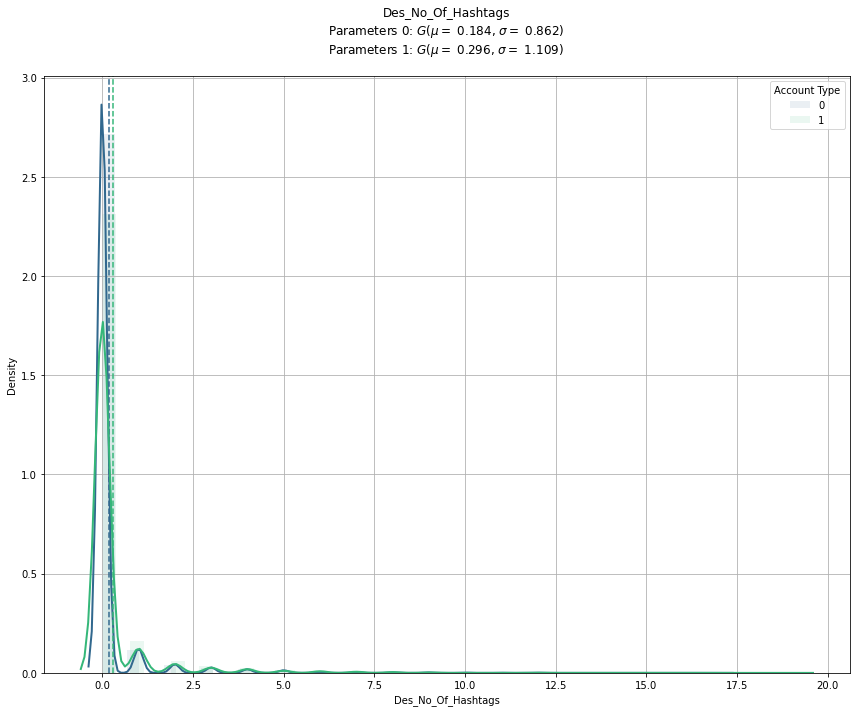

Skewness: 7.024488778328746


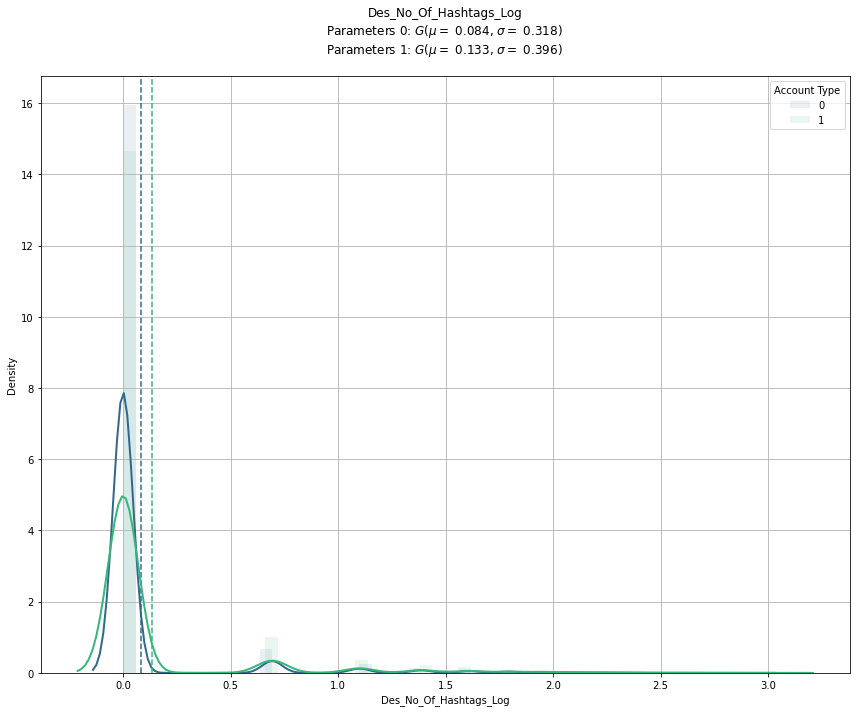

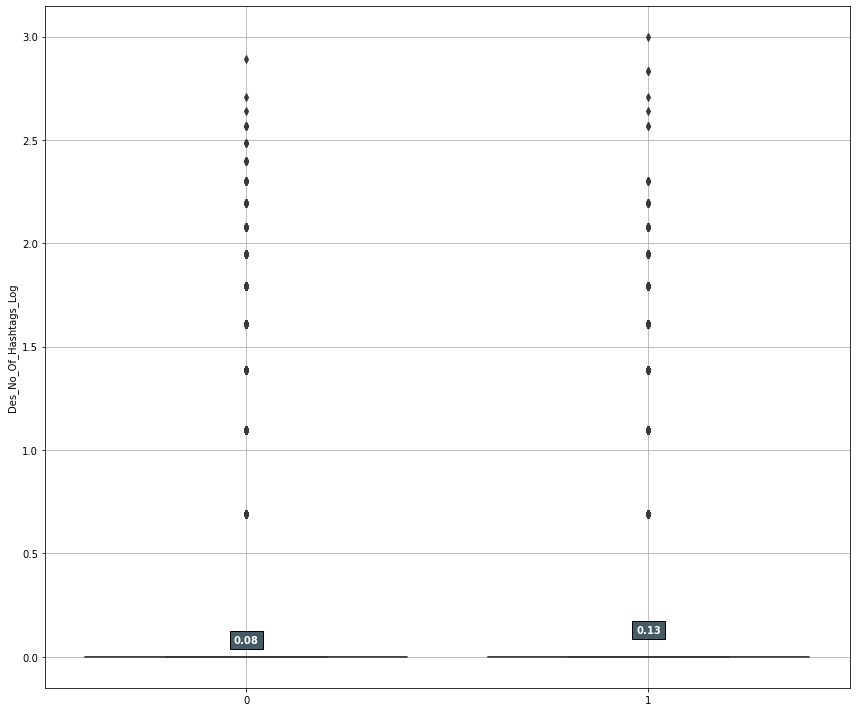

In [28]:
target: str = "des_no_of_hashtags"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

s = skew(df_metadata['des_no_of_hashtags'])
print (f'Skewness: {s}') #data is slightly skewed

#We log transform des_no_of_hashtags to make trends in the data more interpretable. 
df_metadata['des_no_of_hashtags_log'] = np.round(np.log(1 + df_metadata['des_no_of_hashtags']), 3)
target: str = "des_no_of_hashtags_log"  
# Extract histograms
plot_multiple_histograms(data=df_metadata, 
                         grouped_col=grouped,
                         data_labels=data_labels,
                         target_col=target)

# Extract Box-plots
plot_multiple_boxplots(data=df_metadata,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

## Feature Engineering
* Train - Test Split
* Standard Scaler

In [29]:
# Getting X and y
x = df_metadata.drop(columns = ['isBot', 'tweet_count_log', 'followers_count_log', 'following_count_log', 'listed_count_log', 
                                'des_no_of_usertags_log', 'des_no_of_hashtags_log'])
y = df_metadata['isBot']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (16231, 20) (16231,)
Test set: (4058, 20) (4058,)


In [30]:
scaler = StandardScaler()
numeric_variables = ['followers_count', 'following_count', 'listed_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']

In [31]:
x_train[numeric_variables] = scaler.fit_transform(x_train[numeric_variables])
x_test[numeric_variables] = scaler.transform(x_test[numeric_variables])

train_dataset = x_train.copy()
test_dataset = x_test.copy()

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

train_dataset["isBot"] = y_train["isBot"]
test_dataset["isBot"] = y_test["isBot"]

In [32]:
train_dataset

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,account_age_in_days,average_tweets_per_day,followers_following_count,isBot
2722,0,0,0,-0.058996,-0.101765,-0.375390,-0.064435,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,3312,0.034118,4309,1
10118,0,0,0,-0.058509,-0.061982,-0.024002,-0.064274,1,-0.277500,0,-1.193893,0,-0.264936,-0.226362,0,1,0,3506,9.458642,2002648,0
68,0,0,1,-0.058917,-0.092427,-0.206857,-0.062335,1,0.094003,0,0.467797,0,-0.264936,-0.226362,0,1,1,3877,4.117617,111946,0
9927,0,0,1,-0.057353,0.078232,-0.321707,-0.059427,1,1.580014,0,0.098533,0,6.295222,-0.226362,1,1,1,4928,1.047484,27844029,0
330,0,0,1,-0.058873,-0.094191,-0.207697,-0.064112,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,5035,3.154916,145112,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,0,1,1,0.183041,2.307269,0.000665,-0.002560,1,1.580014,1,0.652429,0,-0.264936,-0.226362,1,1,1,3044,11.656373,53374629456,1
8006,0,0,1,-0.058544,-0.093461,-0.219648,-0.057004,1,-0.277500,0,1.390958,0,-0.264936,-0.226362,0,1,0,5015,2.943370,530656,0
17745,0,0,1,-0.058863,-0.095256,-0.194927,-0.062820,1,1.208511,0,0.652429,0,-0.264936,-0.226362,0,1,1,4996,3.419936,141553,0
17931,0,0,0,-0.058952,-0.071228,-0.375411,-0.064274,1,-0.277500,0,-0.270732,0,-0.264936,-0.226362,0,1,1,3304,0.033596,174879,1


In [33]:
test_dataset

,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,un_no_of_char,un_special_char,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,account_age_in_days,average_tweets_per_day,followers_following_count,isBot
18289,0,0,1,-0.058983,-0.100670,-0.376092,-0.063789,1,0.094003,1,-0.086100,0,-0.264936,-0.226362,0,1,0,5060,0.009289,11725,0
10936,0,0,1,-0.058989,-0.103012,-0.357559,-0.063466,1,-0.277500,1,1.206326,0,-0.264936,-0.226362,0,1,1,3599,0.497360,4802,0
18948,0,0,1,-0.058999,-0.105992,-0.292224,-0.064435,1,1.208511,1,1.206326,0,-0.264936,-0.226362,0,1,1,4889,1.623031,0,0
15612,0,0,1,-0.058434,-0.075790,-0.296583,-0.059750,1,-0.649002,0,1.390958,1,1.375103,-0.226362,0,1,1,5081,1.481008,1581849,0
292,0,0,0,-0.046815,-0.021621,2.165586,-0.013061,1,1.580014,1,-1.563157,0,1.375103,-0.226362,0,1,0,5106,46.827066,93994216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5486,0,0,0,-0.058997,-0.100578,-0.375454,-0.064435,1,-0.649002,0,-0.455364,0,-0.264936,-0.226362,0,1,1,3305,0.032375,4984,1
17741,0,0,1,-0.058892,-0.086253,-0.217617,-0.063789,1,-0.277500,0,-1.193893,0,-0.264936,-0.226362,0,1,0,4617,3.238467,207680,0
13771,0,0,1,-0.058947,-0.084458,-0.365236,-0.062335,1,0.465506,0,0.098533,0,3.015143,-0.226362,0,1,0,4106,0.260107,117528,0
12926,0,0,1,-0.058681,-0.097932,-0.282102,-0.020977,1,-1.020505,0,0.098533,0,-0.264936,-0.226362,0,1,1,5822,1.526451,239825,1


In [34]:
train_dataset.to_csv("train_dataset.csv", index = False)
test_dataset.to_csv("test_dataset.csv", index = False)